Author: Amitabh Chakravorty

MODEL TRAINING

Train 6 classical ML models on both datasets

In [1]:
# ============================================================================
# SETUP
# ============================================================================

import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount and navigate
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/cryptojacking_validation'
os.chdir(base_path)

print("Working directory:", os.getcwd())
print("\n")
print("MODEL TRAINING - Classical ML")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/cryptojacking_validation


MODEL TRAINING - Classical ML


In [2]:
# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, dataset_name):
    """
    Train a single model and collect comprehensive metrics
    """
    print("\n")
    print(f"Training: {model_name} on {dataset_name}")
    print("\n")

    # Training
    print("Training")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Prediction
    print("Predicting")
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    # Display results
    print(f"\n Results:")
    print(f"  Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  F1-Score:     {f1:.4f}")
    print(f"  Precision:    {precision:.4f}")
    print(f"  Recall:       {recall:.4f}")
    print(f"  Train time:   {train_time:.2f}s")
    print(f"  Inference:    {inference_time:.4f}s")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n Confusion Matrix:")
    print(f"                Predicted")
    print(f"              Normal  Attack")
    print(f"Actual Normal  {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"       Attack  {cm[1,0]:6d}  {cm[1,1]:6d}")

    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    print(f"\n Error Analysis:")
    print(f"  False Positive Rate: {fpr:.4f} ({fp:,} false alarms)")
    print(f"  False Negative Rate: {fnr:.4f} ({fn:,} missed attacks)")

    # Save model
    model_path = f'models/{model_name.replace(" ", "_")}_{dataset_name}.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n Model saved: {model_path}")

    # Return results dictionary
    results = {
        'model': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'train_time_sec': train_time,
        'inference_time_sec': inference_time,
        'samples_train': len(y_train),
        'samples_test': len(y_test),
        'features': X_train.shape[1],
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'fpr': fpr,
        'fnr': fnr
    }

    return results, cm

In [3]:
# ============================================================================
# TRAIN ALL MODELS ON ONE DATASET
# ============================================================================

def train_all_models_on_dataset(dataset_name):
    """
    Train all models on a specific dataset
    """
    print("\n")
    print(f"# DATASET: {dataset_name.upper()}")
    print("\n")

    # Load data
    try:
        X_train = np.load(f'data/processed/X_train_{dataset_name}.npy')
        X_test = np.load(f'data/processed/X_test_{dataset_name}.npy')
        y_train = np.load(f'data/processed/y_train_{dataset_name}.npy')
        y_test = np.load(f'data/processed/y_test_{dataset_name}.npy')

        print(f"\n Data loaded:")
        print(f"  Train: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
        print(f"  Test:  {X_test.shape[0]:,} samples")
        print(f"  Train - Normal: {np.sum(y_train==0):,}, Attack: {np.sum(y_train==1):,}")
        print(f"  Test  - Normal: {np.sum(y_test==0):,}, Attack: {np.sum(y_test==1):,}")

    except FileNotFoundError as e:
        print(f" Dataset not found: {e}")
        return [], []

    # Define models (matching your Table 6 studies)
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            max_depth=20,
            min_samples_split=5
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            max_depth=10,
            learning_rate=0.1,
            eval_metric='logloss'
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            max_depth=10,
            verbose=-1
        ),
        'Decision Tree': DecisionTreeClassifier(
            random_state=42,
            max_depth=15,
            min_samples_split=5
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=5,
            learning_rate=0.1
        )
    }

    # Train each model
    all_results = []
    all_cms = []

    for model_name, model in models.items():
        try:
            results, cm = train_and_evaluate_model(
                model, model_name,
                X_train, X_test, y_train, y_test,
                dataset_name
            )
            all_results.append(results)
            all_cms.append((model_name, cm))
        except Exception as e:
            print(f" Error training {model_name}: {e}")
            import traceback
            traceback.print_exc()

    return all_results, all_cms



In [4]:

# ============================================================================
# VISUALIZATION FUNCTION
# ============================================================================

def plot_confusion_matrices(cms_list, dataset_name):
    """
    Plot confusion matrices for all models
    """
    n_models = len(cms_list)
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()

    for idx, (model_name, cm) in enumerate(cms_list):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_xticklabels(['Normal', 'Attack'])
        axes[idx].set_yticklabels(['Normal', 'Attack'])

    # Hide extra subplots
    for idx in range(len(cms_list), len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Confusion Matrices - {dataset_name.upper()}',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'results/figures/confusion_matrices_{dataset_name}.png',
                dpi=300, bbox_inches='tight')
    print(f"\n Confusion matrices saved: results/figures/confusion_matrices_{dataset_name}.png")
    plt.show()






* TRAINING ON: DS2OS





# DATASET: DS2OS



 Data loaded:
  Train: 487,108 samples, 12 features
  Test:  107,386 samples
  Train - Normal: 243,554, Attack: 243,554
  Test  - Normal: 104,381, Attack: 3,005


Training: Random Forest on ds2os


Training
Predicting

 Results:
  Accuracy:     1.0000 (100.00%)
  F1-Score:     1.0000
  Precision:    1.0000
  Recall:       1.0000
  Train time:   65.59s
  Inference:    0.5665s

 Confusion Matrix:
                Predicted
              Normal  Attack
Actual Normal  104381       0
       Attack       0    3005

 Error Analysis:
  False Positive Rate: 0.0000 (0 false alarms)
  False Negative Rate: 0.0000 (0 missed attacks)

 Model saved: models/Random_Forest_ds2os.pkl


Training: XGBoost on ds2os


Training
Predicting

 Results:
  Accuracy:     1.0000 (100.00%)
  F1-Score:     1.0000
  Precision:    1.0000
  Recall:       1.0000
  Train time:   6.84s
  Inference:    0.3571s

 Confusion Matrix:
                Predicted
              Normal  

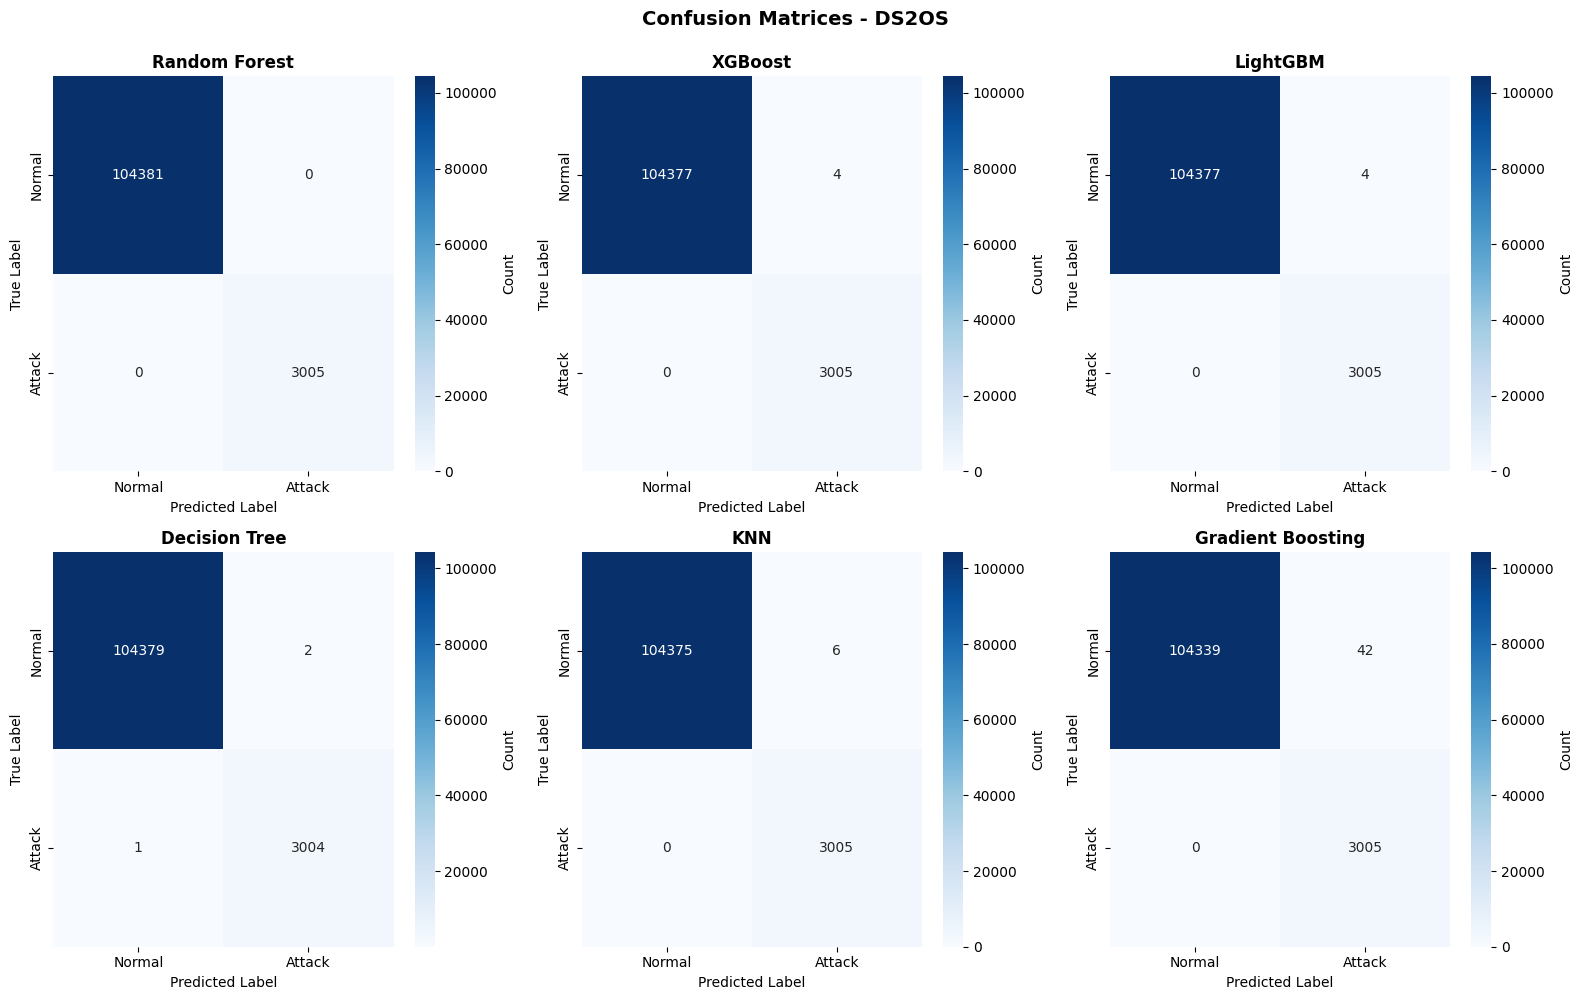




* TRAINING ON: NSL_KDD





# DATASET: NSL_KDD



 Data loaded:
  Train: 125,973 samples, 41 features
  Test:  22,544 samples
  Train - Normal: 67,343, Attack: 58,630
  Test  - Normal: 9,711, Attack: 12,833


Training: Random Forest on nsl_kdd


Training
Predicting

 Results:
  Accuracy:     0.7717 (77.17%)
  F1-Score:     0.7686
  Precision:    0.8345
  Recall:       0.7717
  Train time:   11.46s
  Inference:    0.1809s

 Confusion Matrix:
                Predicted
              Normal  Attack
Actual Normal    9439     272
       Attack    4875    7958

 Error Analysis:
  False Positive Rate: 0.0280 (272 false alarms)
  False Negative Rate: 0.3799 (4,875 missed attacks)

 Model saved: models/Random_Forest_nsl_kdd.pkl


Training: XGBoost on nsl_kdd


Training
Predicting

 Results:
  Accuracy:     0.8082 (80.82%)
  F1-Score:     0.8073
  Precision:    0.8527
  Recall:       0.8082
  Train time:   5.05s
  Inference:    0.1893s

 Confusion Matrix:
                Predicted
            

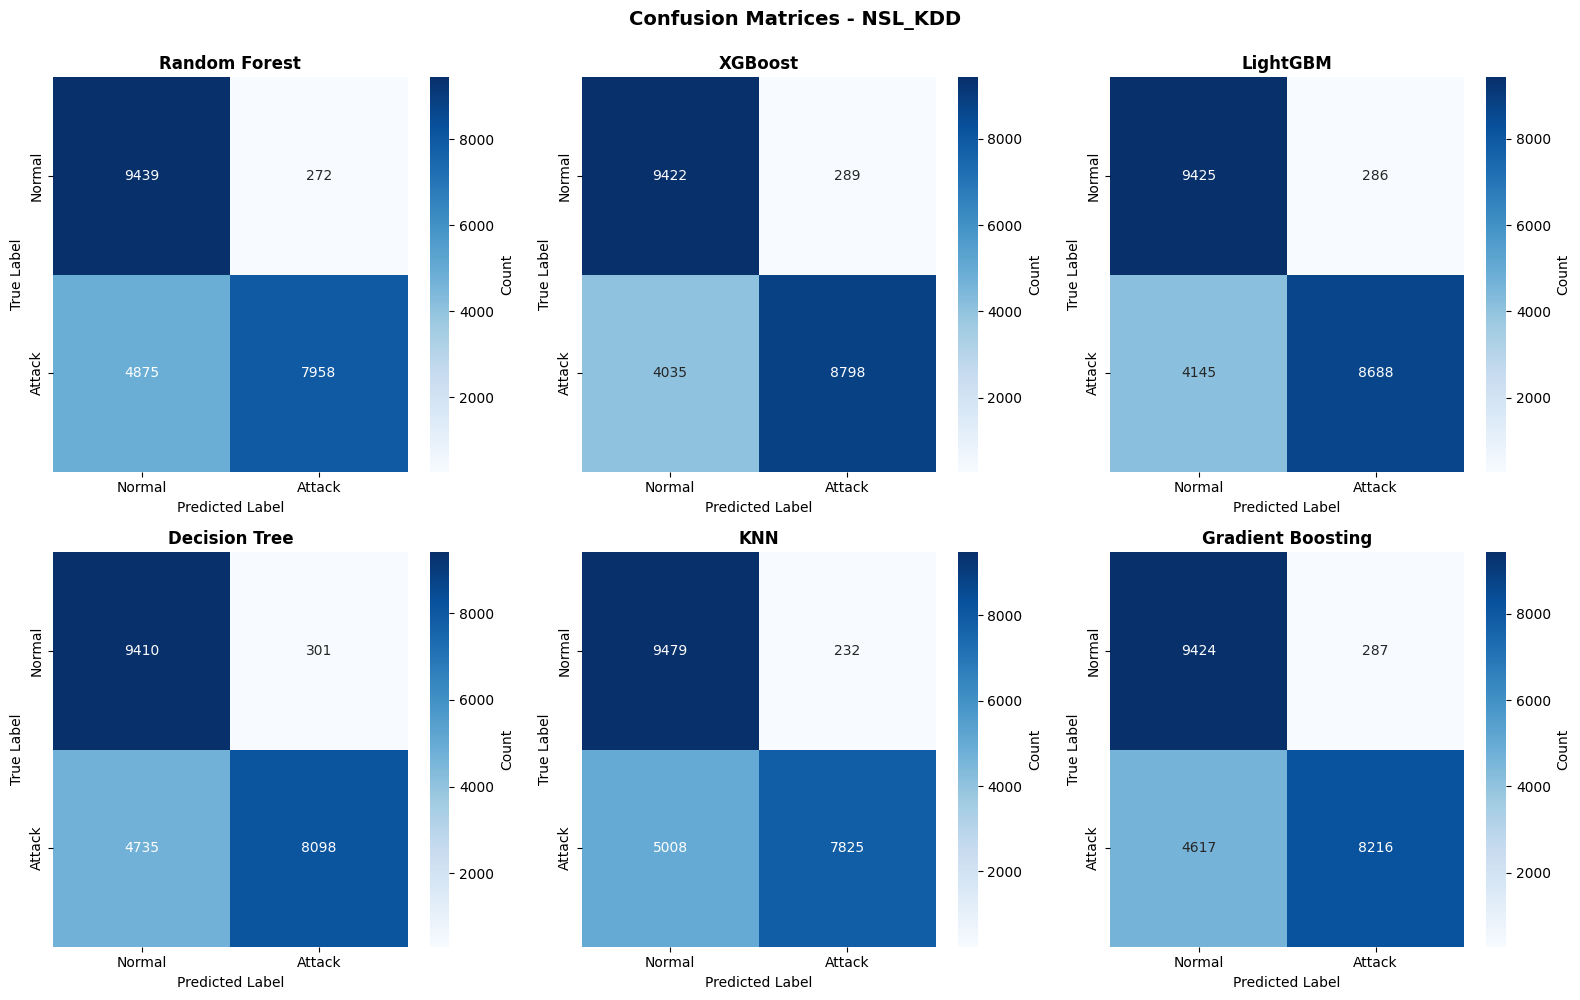

In [5]:
# ============================================================================
# RUN TRAINING
# ============================================================================

datasets_to_train = ['ds2os', 'nsl_kdd']

all_results_combined = []
all_cms_combined = {}

for dataset in datasets_to_train:
    print("\n\n")
    print(f"* TRAINING ON: {dataset.upper()}")
    print("\n\n")

    try:
        results, cms = train_all_models_on_dataset(dataset)
        all_results_combined.extend(results)
        all_cms_combined[dataset] = cms

        # Plot confusion matrices
        if cms:
            plot_confusion_matrices(cms, dataset)

    except Exception as e:
        print(f"Error processing {dataset}: {e}")
        import traceback
        traceback.print_exc()

In [6]:
# ============================================================================
# SAVE ALL RESULTS
# ============================================================================

print("\n\n")
print("SAVING RESULTS")
print("\n\n")

# Convert to DataFrame
results_df = pd.DataFrame(all_results_combined)

# Display summary
print("\nPERFORMANCE SUMMARY:")
print("="*70)
summary_cols = ['model', 'dataset', 'accuracy', 'f1_score', 'precision', 'recall', 'train_time_sec']
print(results_df[summary_cols].to_string(index=False))

# Save to CSV
results_df.to_csv('results/metrics/model_performance.csv', index=False)
print("\n Results saved to: results/metrics/model_performance.csv")




SAVING RESULTS




PERFORMANCE SUMMARY:
            model dataset  accuracy  f1_score  precision   recall  train_time_sec
    Random Forest   ds2os  1.000000  1.000000   1.000000 1.000000       65.585452
          XGBoost   ds2os  0.999963  0.999963   0.999963 0.999963        6.841301
         LightGBM   ds2os  0.999963  0.999963   0.999963 0.999963        5.141477
    Decision Tree   ds2os  0.999972  0.999972   0.999972 0.999972        3.459731
              KNN   ds2os  0.999944  0.999944   0.999944 0.999944        2.144180
Gradient Boosting   ds2os  0.999609  0.999610   0.999614 0.999609      190.175945
    Random Forest nsl_kdd  0.771691  0.768615   0.834481 0.771691       11.463868
          XGBoost nsl_kdd  0.808197  0.807314   0.852736 0.808197        5.049117
         LightGBM nsl_kdd  0.803451  0.802350   0.850282 0.803451        2.367340
    Decision Tree nsl_kdd  0.776615  0.774049   0.835405 0.776615        1.152478
              KNN nsl_kdd  0.767566  0.763933   0.83470


 Creating comparison visualizations...
Saved: results/figures/accuracy_comparison.png


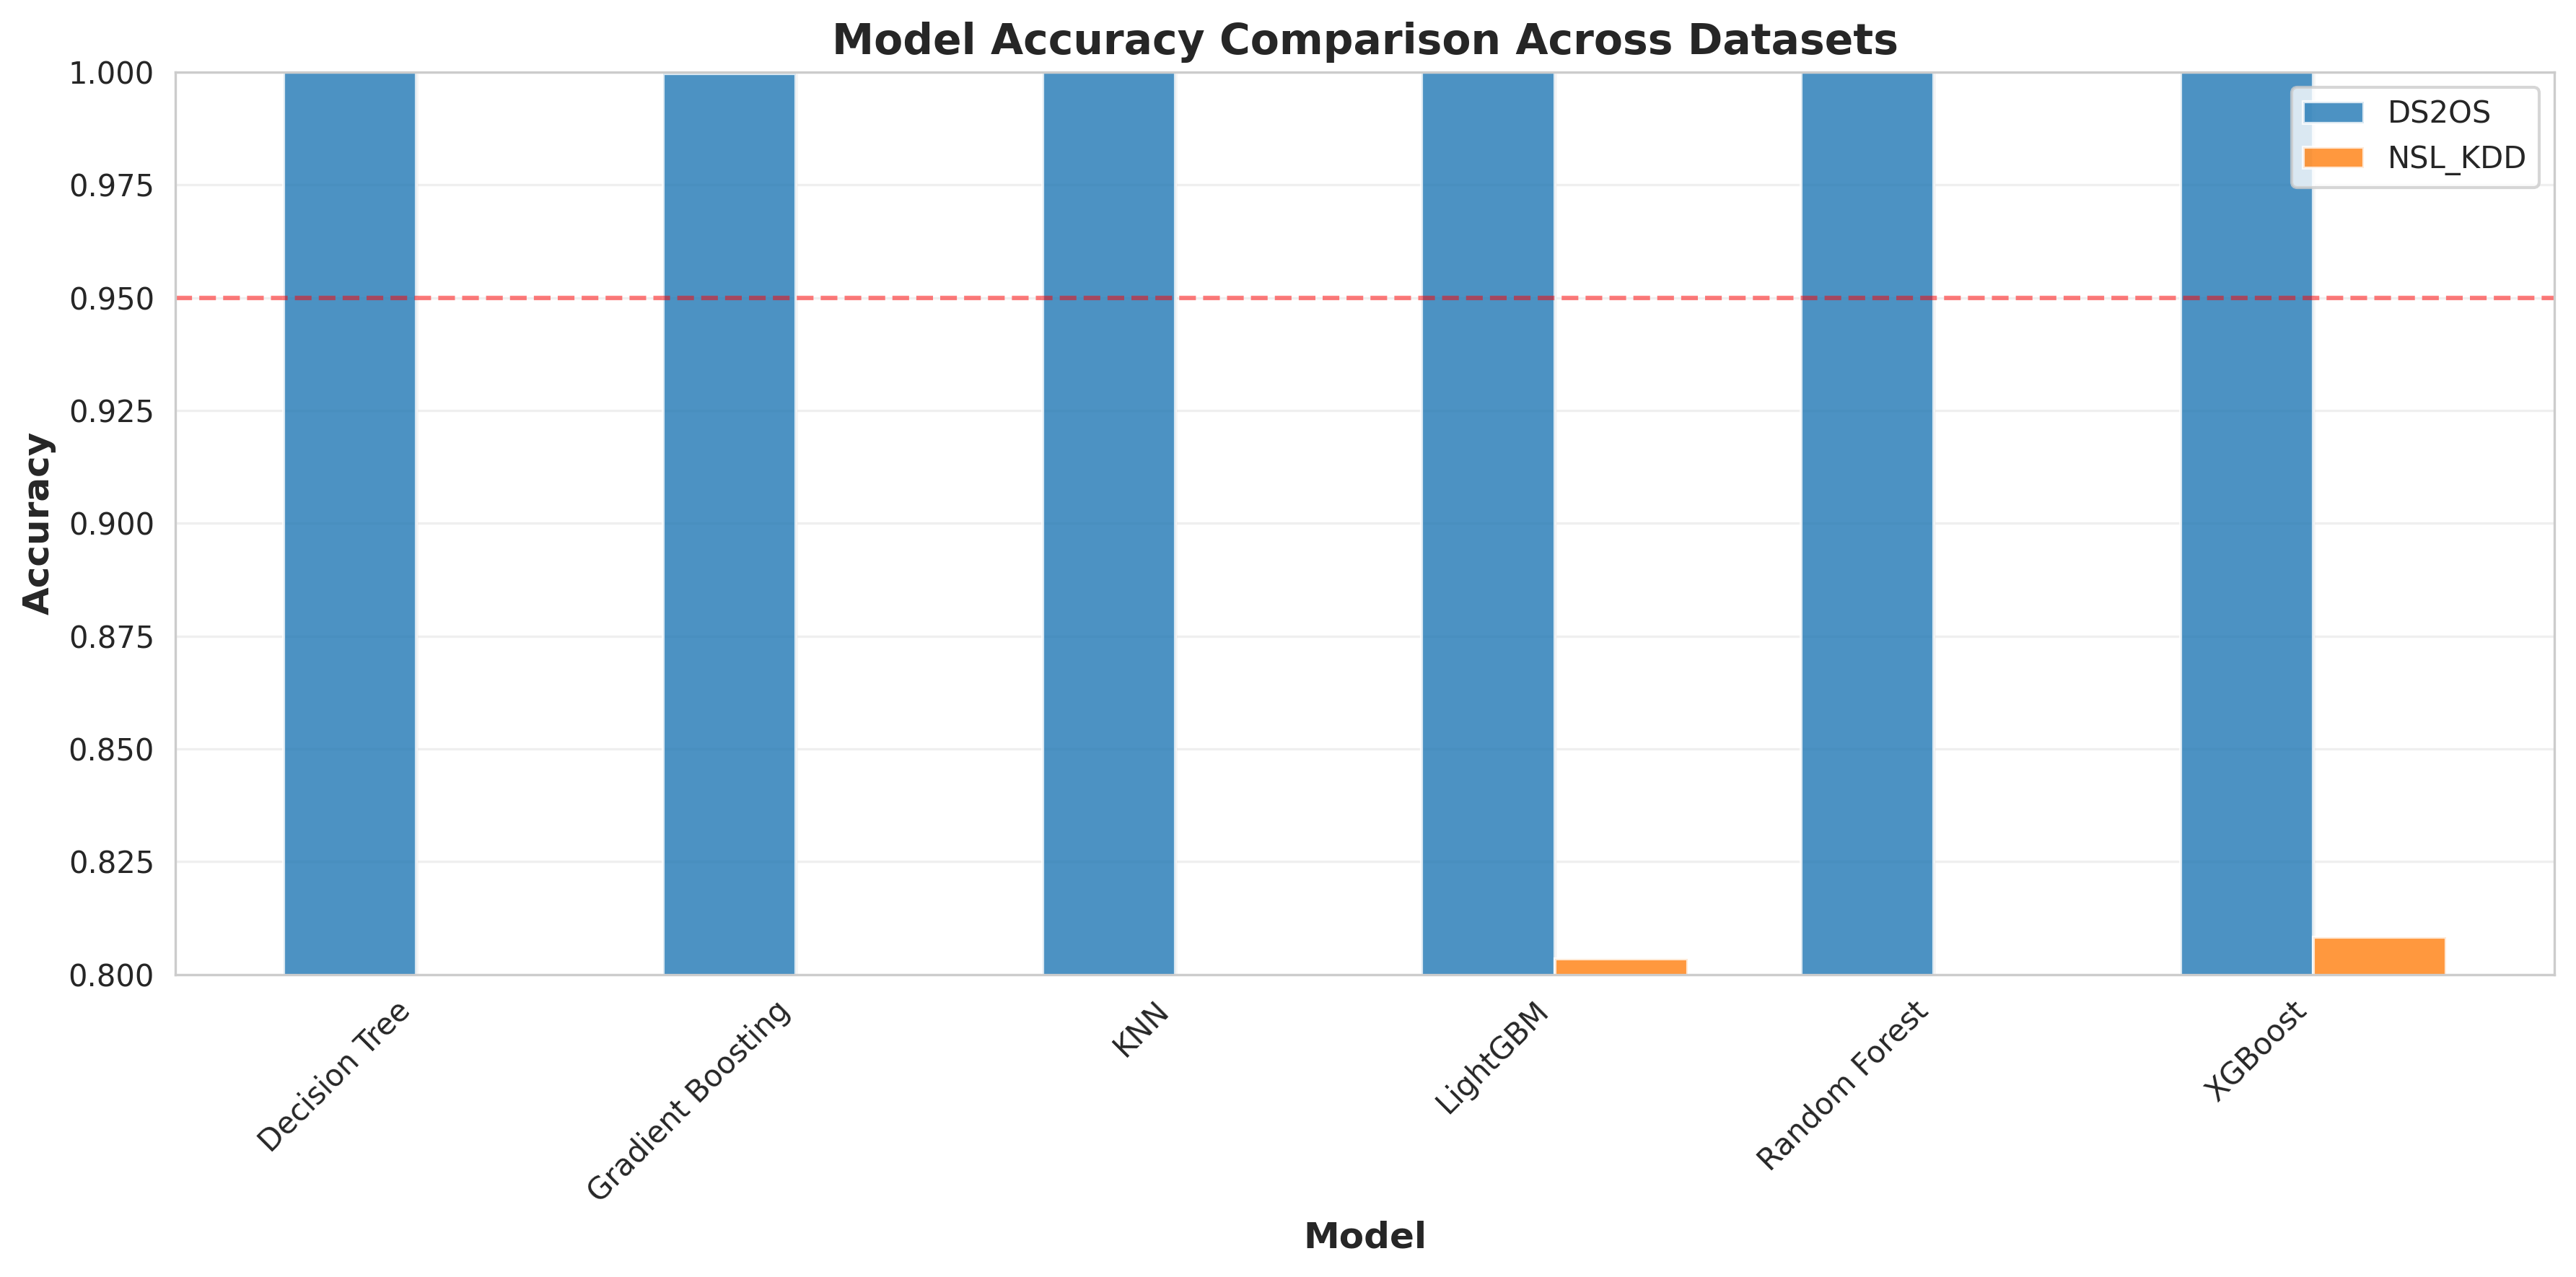

Saved: results/figures/f1_comparison.png


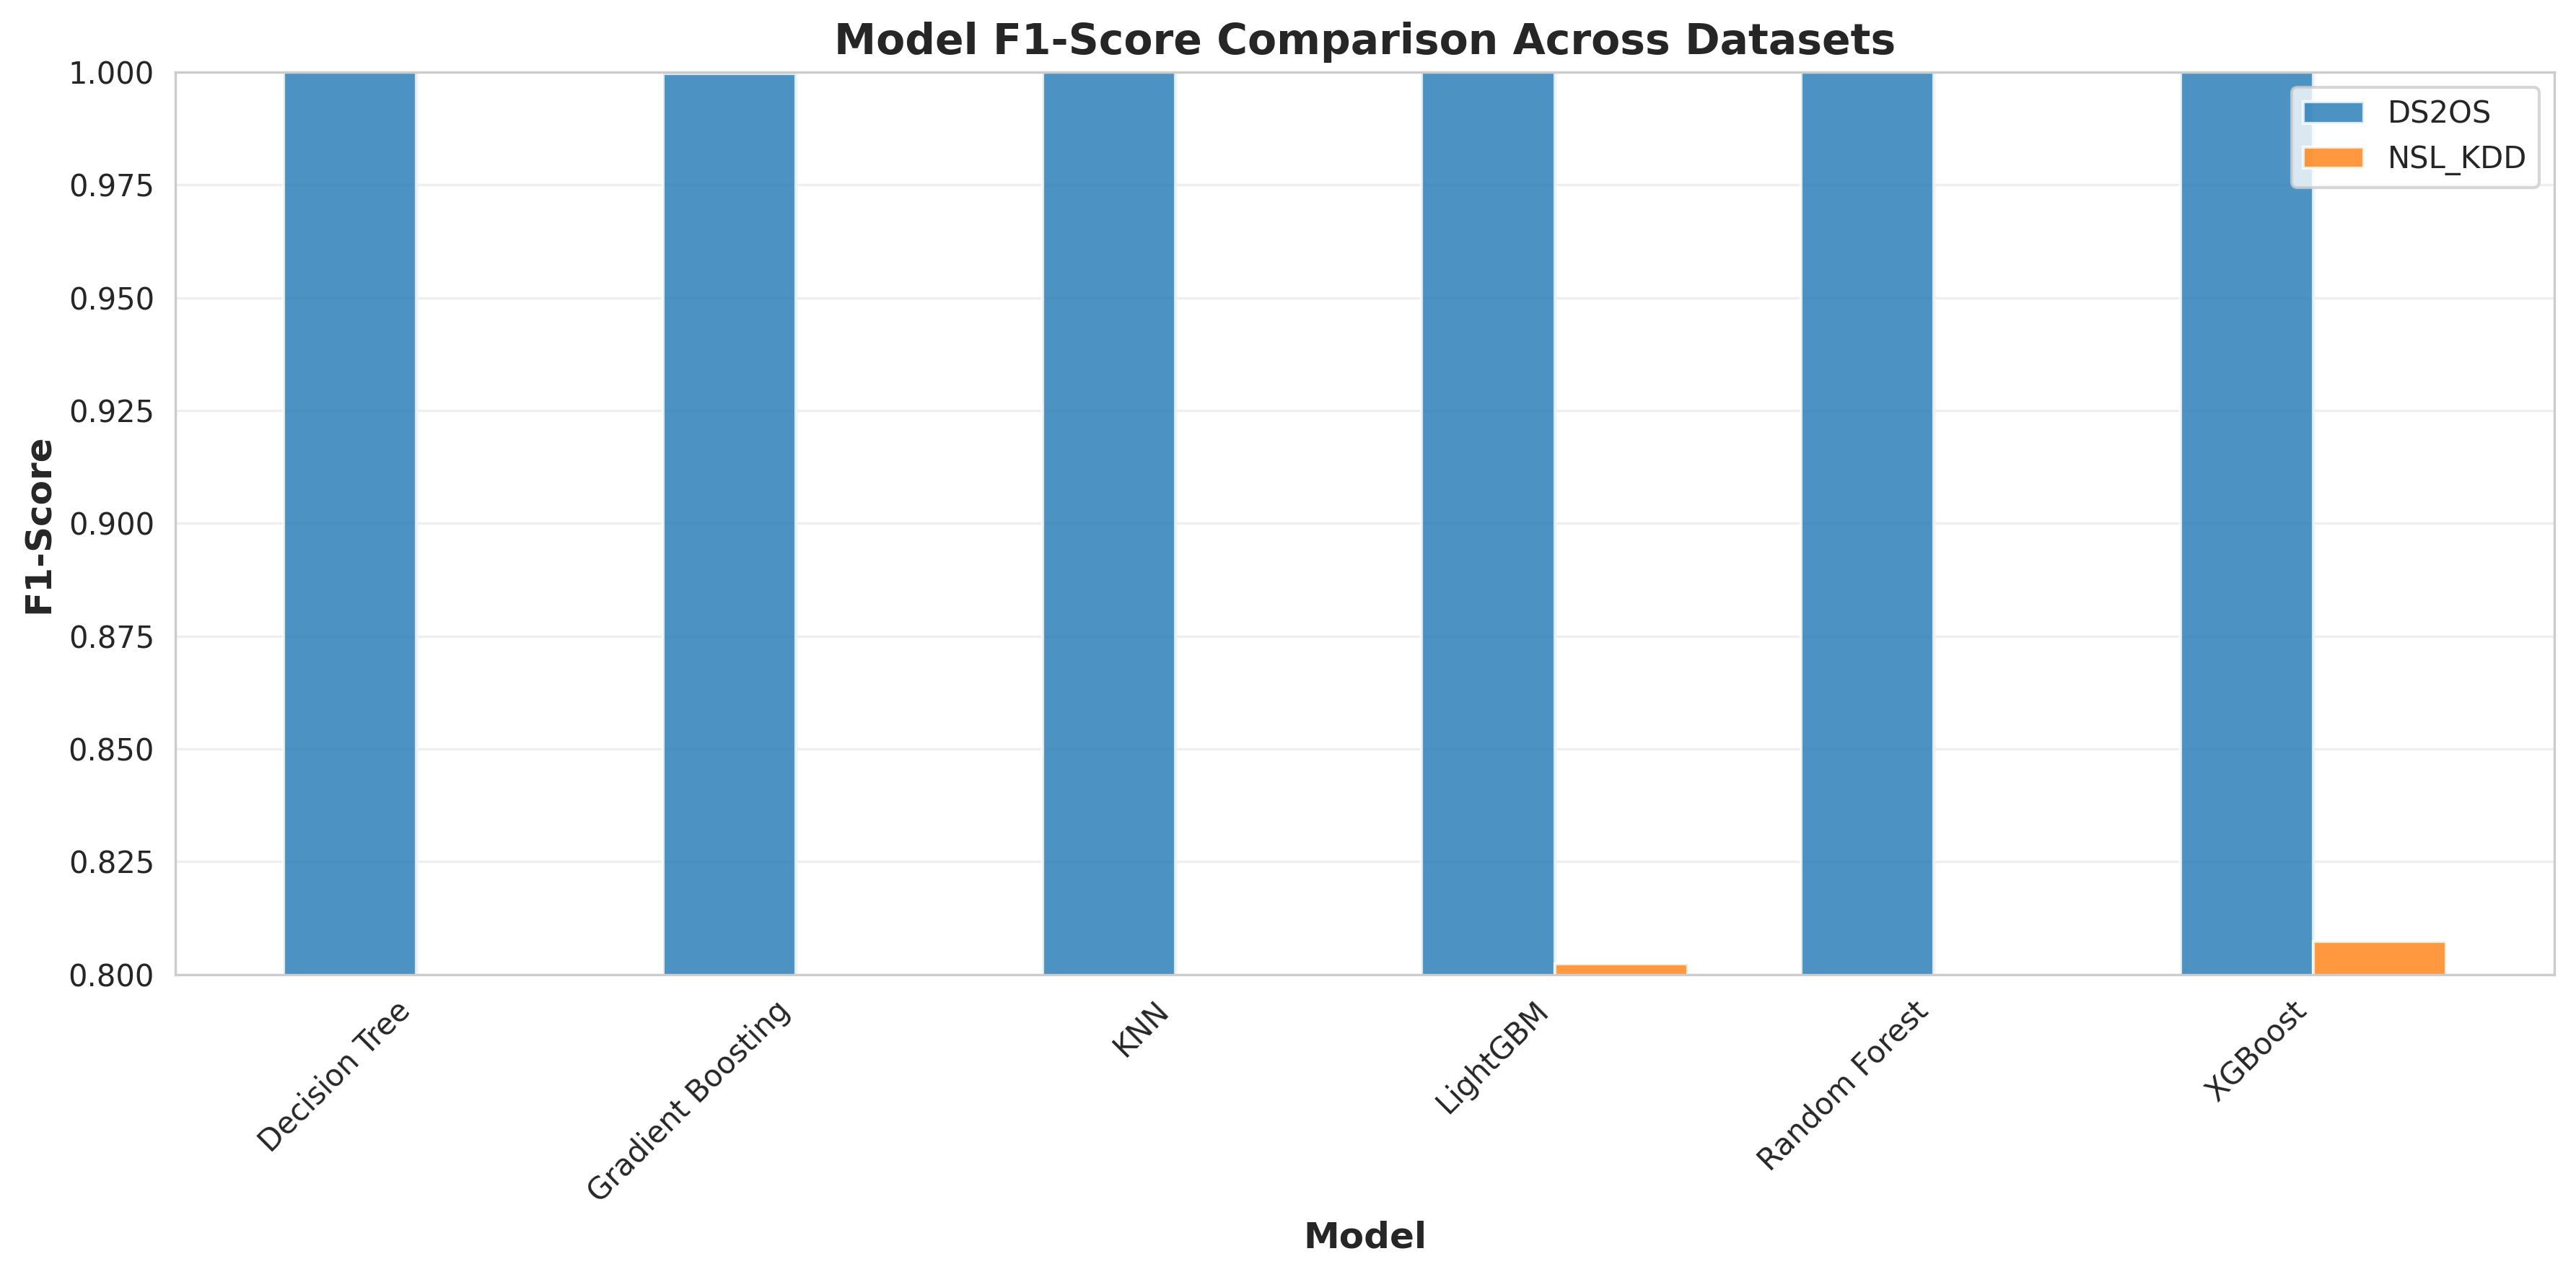

Saved: results/figures/computational_cost.png


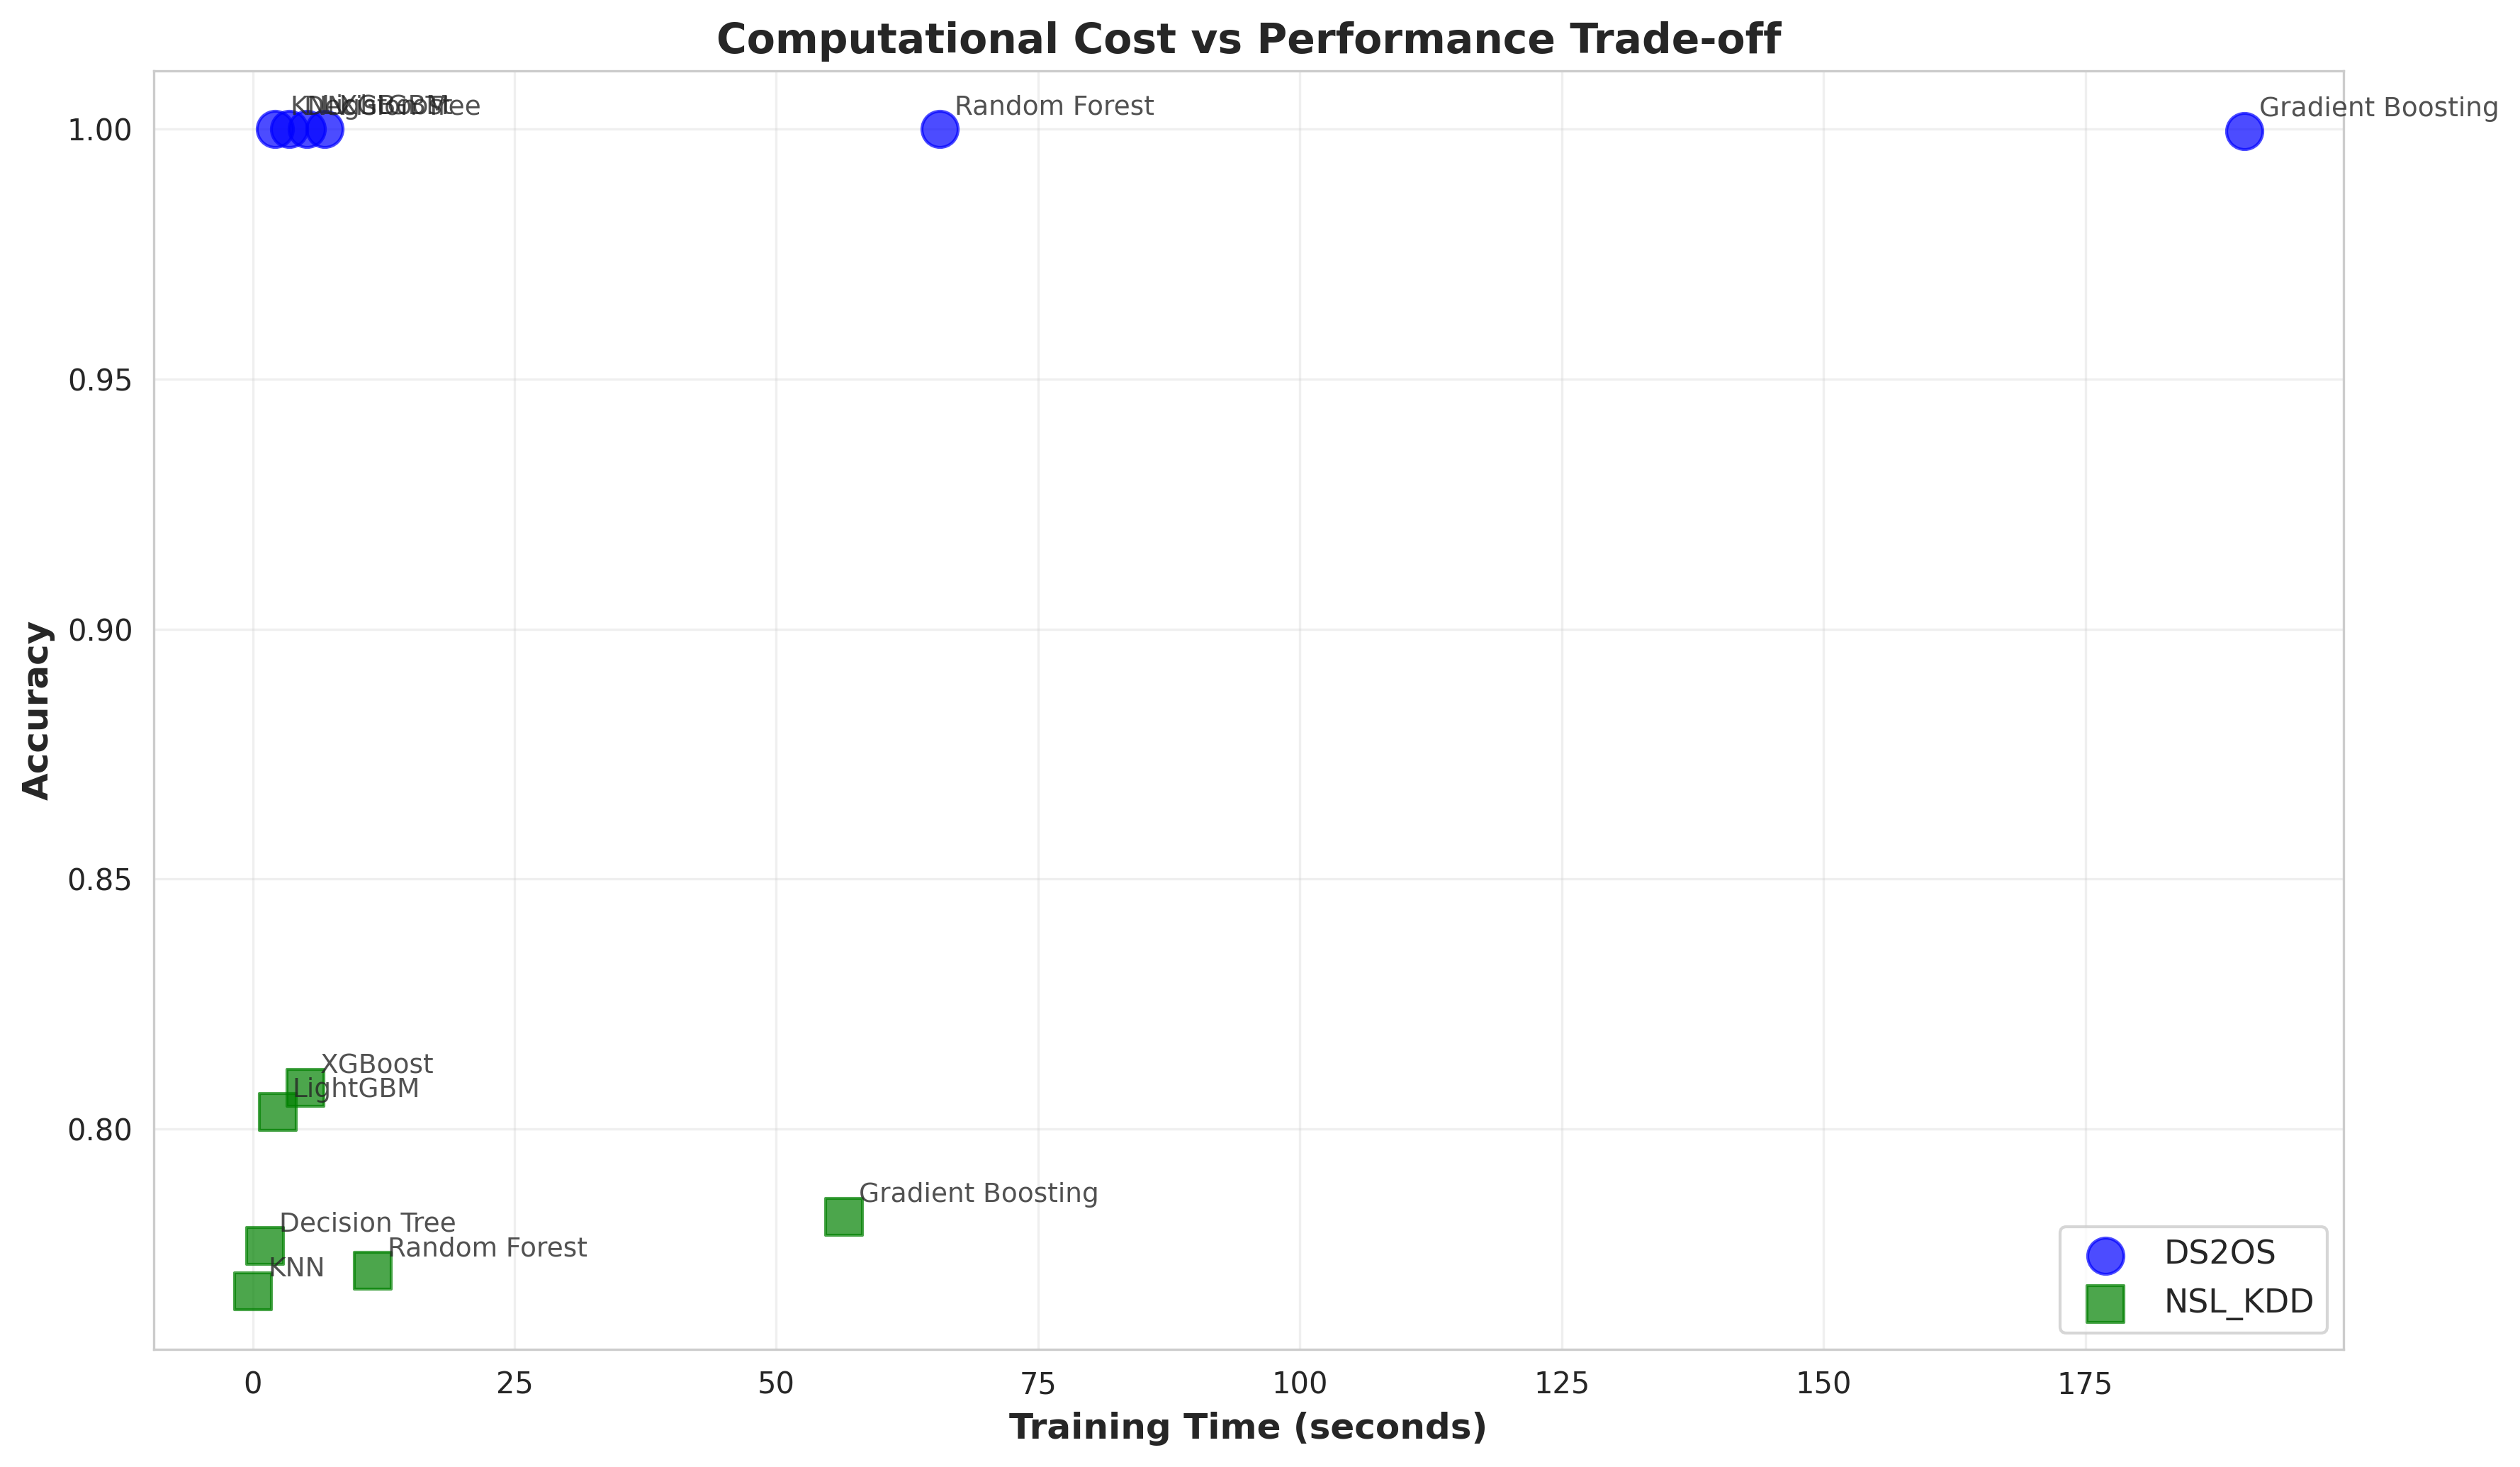

Saved: results/figures/accuracy_heatmap.png


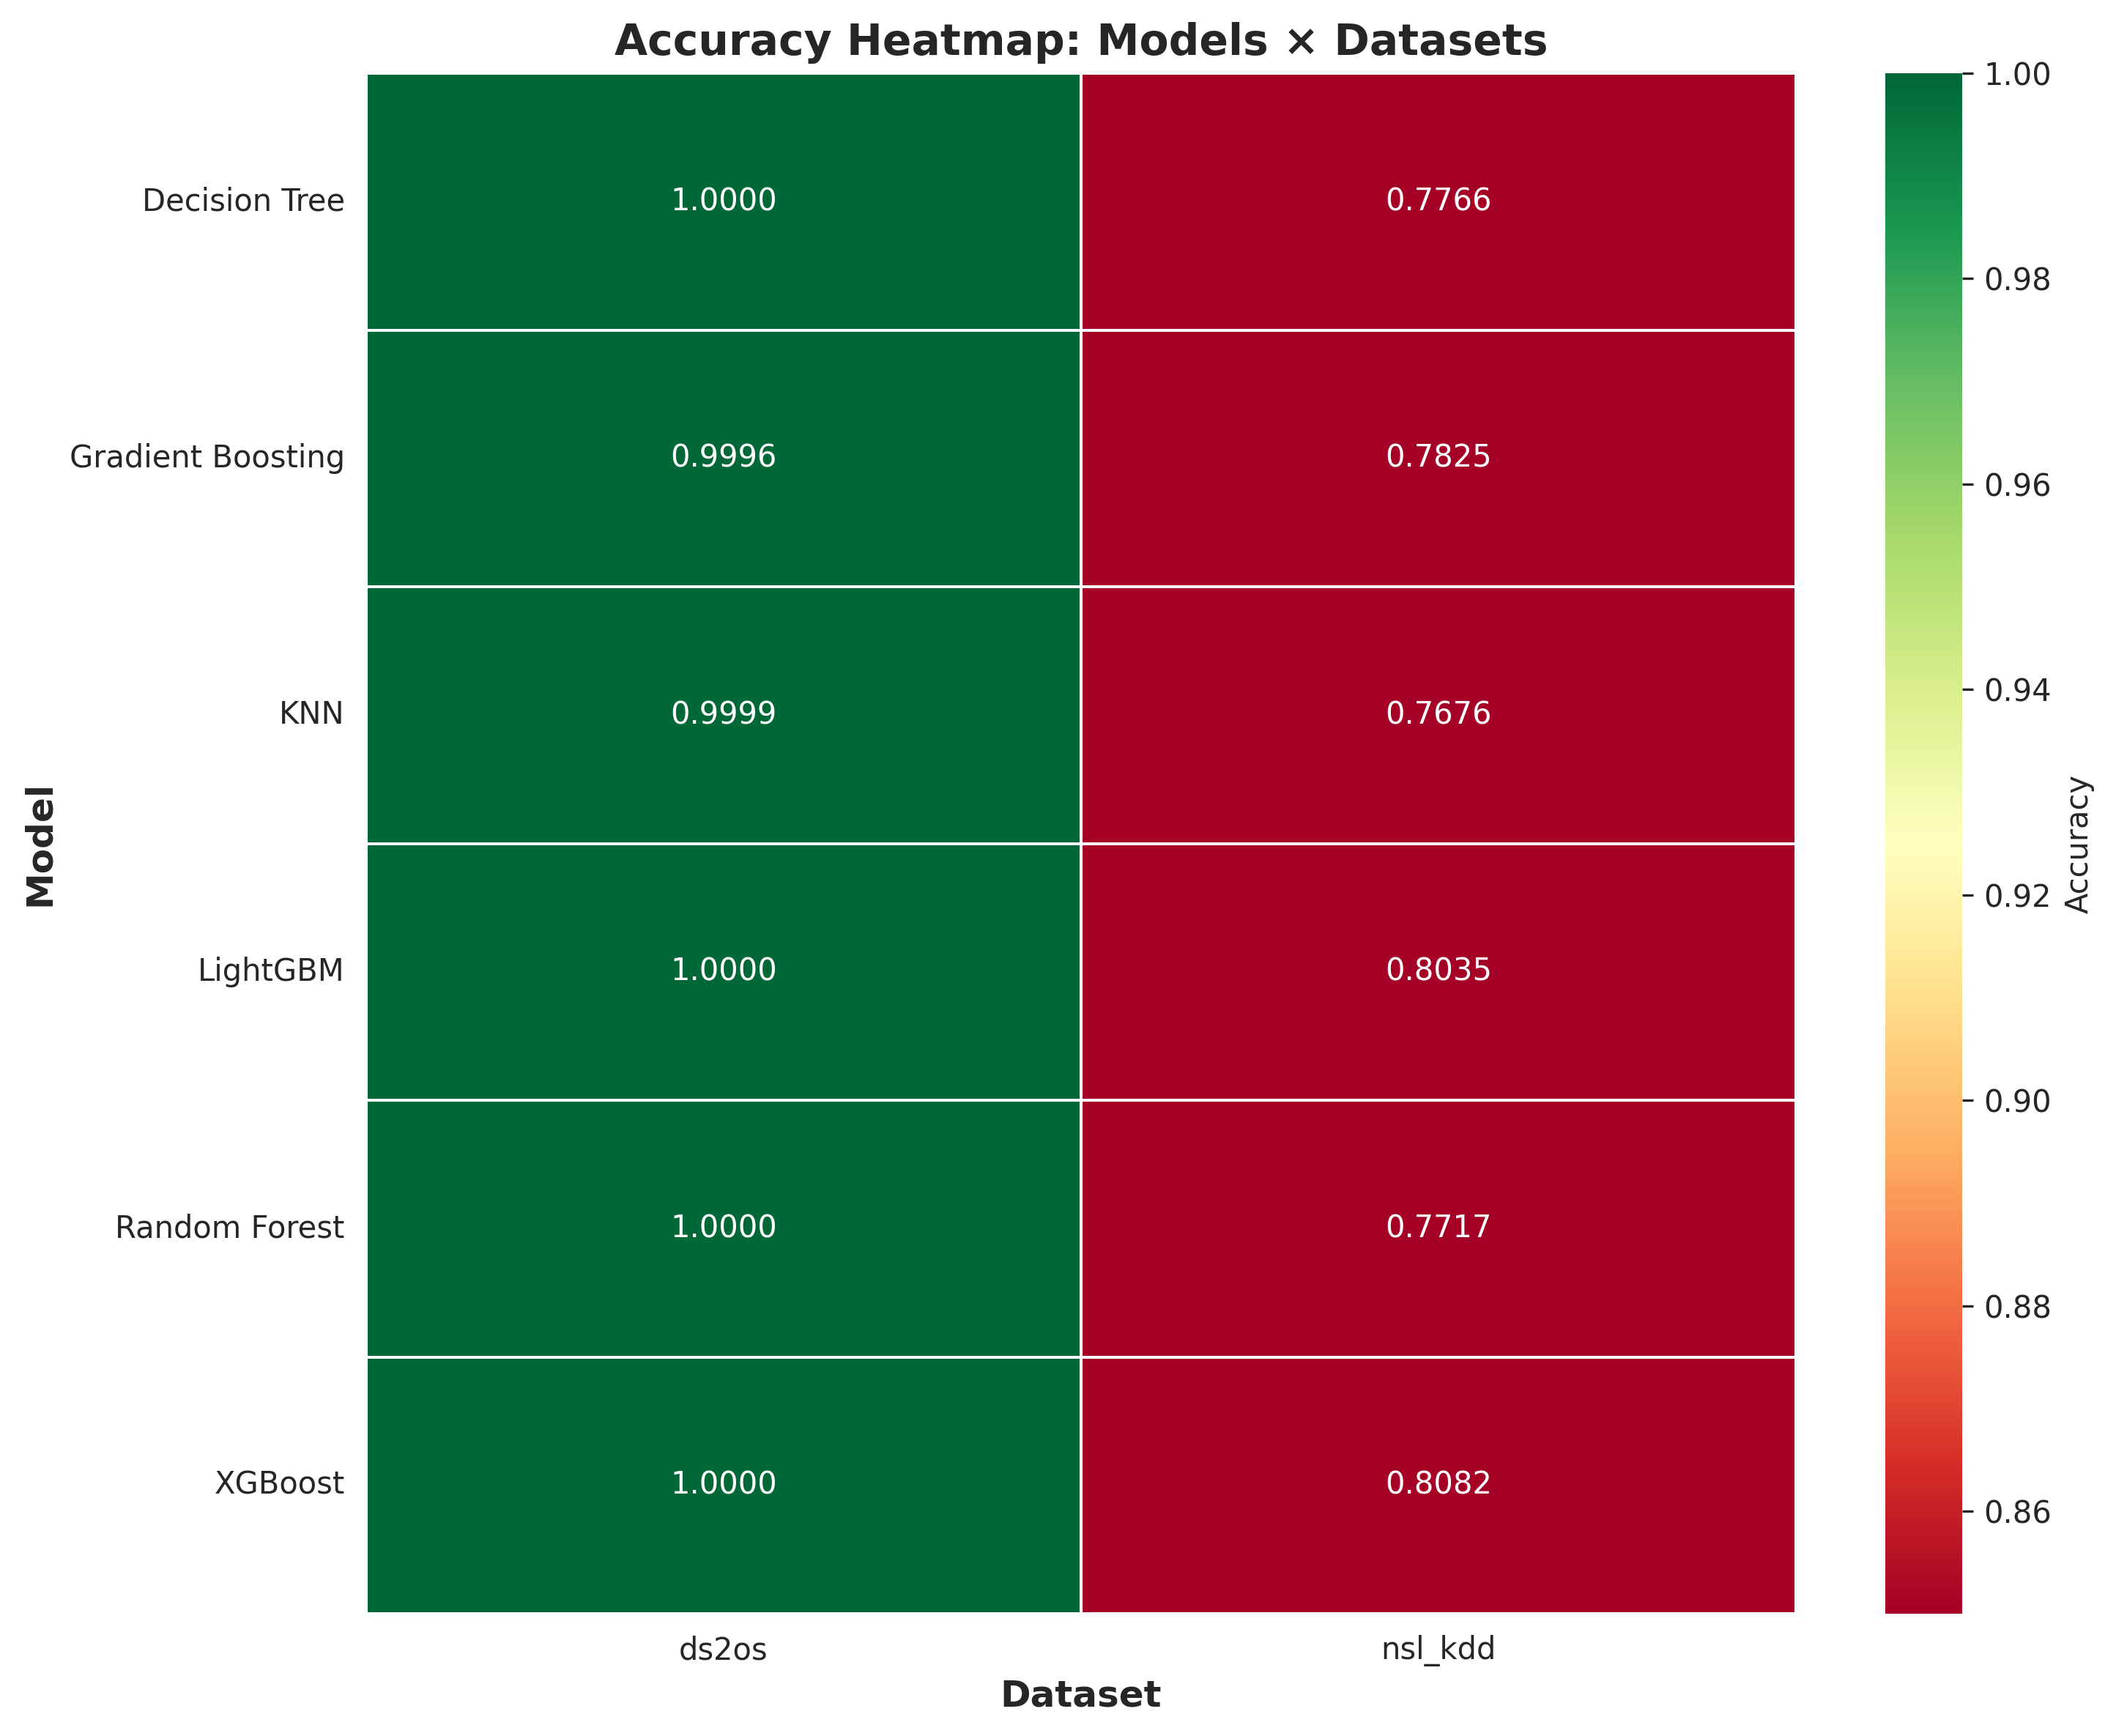

In [7]:
# ============================================================================
# CREATE VISUALIZATIONS
# ============================================================================

print("\n Creating comparison visualizations...")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# 1. Accuracy Comparison
fig, ax = plt.subplots(figsize=(12, 6))

datasets = results_df['dataset'].unique()
x = np.arange(len(results_df[results_df['dataset']==datasets[0]]))
width = 0.35

for i, dataset in enumerate(datasets):
    subset = results_df[results_df['dataset'] == dataset].sort_values('model')
    ax.bar(x + i*width, subset['accuracy'], width,
           label=dataset.upper(), alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison Across Datasets', fontsize=14, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(subset['model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.80, 1.0])
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% threshold')

plt.tight_layout()
plt.savefig('results/figures/accuracy_comparison.png', bbox_inches='tight')
print("Saved: results/figures/accuracy_comparison.png")
plt.show()

# 2. F1-Score Comparison
fig, ax = plt.subplots(figsize=(12, 6))

for i, dataset in enumerate(datasets):
    subset = results_df[results_df['dataset'] == dataset].sort_values('model')
    ax.bar(x + i*width, subset['f1_score'], width,
           label=dataset.upper(), alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Model F1-Score Comparison Across Datasets', fontsize=14, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(subset['model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.80, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/f1_comparison.png', bbox_inches='tight')
print("Saved: results/figures/f1_comparison.png")
plt.show()

# 3. Training Time vs Accuracy Trade-off
fig, ax = plt.subplots(figsize=(12, 7))

colors = {'ds2os': 'blue', 'nsl_kdd': 'green'}
markers = {'ds2os': 'o', 'nsl_kdd': 's'}

for dataset in datasets:
    subset = results_df[results_df['dataset'] == dataset]
    ax.scatter(subset['train_time_sec'], subset['accuracy'],
               s=150, alpha=0.7, label=dataset.upper(),
               color=colors[dataset], marker=markers[dataset])

    # Annotate points
    for idx, row in subset.iterrows():
        ax.annotate(row['model'],
                    (row['train_time_sec'], row['accuracy']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)

ax.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Computational Cost vs Performance Trade-off', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/computational_cost.png', bbox_inches='tight')
print("Saved: results/figures/computational_cost.png")
plt.show()

# 4. Performance Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Pivot for heatmap
heatmap_data = results_df.pivot_table(
    values='accuracy',
    index='model',
    columns='dataset'
)

sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn',
            vmin=0.85, vmax=1.0, cbar_kws={'label': 'Accuracy'},
            linewidths=0.5, ax=ax)
ax.set_title('Accuracy Heatmap: Models × Datasets', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/accuracy_heatmap.png', bbox_inches='tight')
print("Saved: results/figures/accuracy_heatmap.png")
plt.show()


In [8]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n\n")
print("TRAINING COMPLETE!")
print("\n\n")

print(f"\n Overall Statistics:")
print(f"  Total models trained: {len(all_results_combined)}")
print(f"  Datasets: {len(datasets)}")
print(f"  Models per dataset: {len(all_results_combined) // len(datasets)}")

print(f"\n Best Performers:")
best_acc = results_df.loc[results_df['accuracy'].idxmax()]
print(f"  Highest Accuracy: {best_acc['model']} on {best_acc['dataset'].upper()} - {best_acc['accuracy']:.4f}")

best_f1 = results_df.loc[results_df['f1_score'].idxmax()]
print(f"  Highest F1-Score: {best_f1['model']} on {best_f1['dataset'].upper()} - {best_f1['f1_score']:.4f}")

fastest = results_df.loc[results_df['train_time_sec'].idxmin()]
print(f"  Fastest Training: {fastest['model']} on {fastest['dataset'].upper()} - {fastest['train_time_sec']:.2f}s")

print(f"\n Average Performance:")
print(f"  Mean Accuracy:  {results_df['accuracy'].mean():.4f}")
print(f"  Mean F1-Score:  {results_df['f1_score'].mean():.4f}")
print(f"  Mean Precision: {results_df['precision'].mean():.4f}")
print(f"  Mean Recall:    {results_df['recall'].mean():.4f}")

print(f"\n Computational Summary:")
print(f"  Total training time: {results_df['train_time_sec'].sum():.2f}s ({results_df['train_time_sec'].sum()/60:.2f} min)")
print(f"  Average per model:   {results_df['train_time_sec'].mean():.2f}s")

print("\n Files Created:")
print(f" results/metrics/model_performance.csv")
print(f" results/figures/confusion_matrices_ds2os.png")
print(f" results/figures/confusion_matrices_nsl_kdd.png")
print(f" results/figures/accuracy_comparison.png")
print(f" results/figures/f1_comparison.png")
print(f" results/figures/computational_cost.png")
print(f" results/figures/accuracy_heatmap.png")
print(f" {len(all_results_combined)} trained model files in models/")




TRAINING COMPLETE!




 Overall Statistics:
  Total models trained: 12
  Datasets: 2
  Models per dataset: 6

 Best Performers:
  Highest Accuracy: Random Forest on DS2OS - 1.0000
  Highest F1-Score: Random Forest on DS2OS - 1.0000
  Fastest Training: KNN on NSL_KDD - 0.04s

 Average Performance:
  Mean Accuracy:  0.8925
  Mean F1-Score:  0.8913
  Mean Precision: 0.9205
  Mean Recall:    0.8925

 Computational Summary:
  Total training time: 349.88s (5.83 min)
  Average per model:   29.16s

 Files Created:
 results/metrics/model_performance.csv
 results/figures/confusion_matrices_ds2os.png
 results/figures/confusion_matrices_nsl_kdd.png
 results/figures/accuracy_comparison.png
 results/figures/f1_comparison.png
 results/figures/computational_cost.png
 results/figures/accuracy_heatmap.png
 12 trained model files in models/
